In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import hashlib 

In [2]:
titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (10, 8)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

# 1. Множественное тестирование
## 1.1. FWER - групповая вероятность ошибки первого рода
Посмотрим как меняется FWER при увеличении кол-ва экспериментов
$$FWER = \mathbb{P}(FP > 0)$$
$FP$ - число ложно положительных результатов

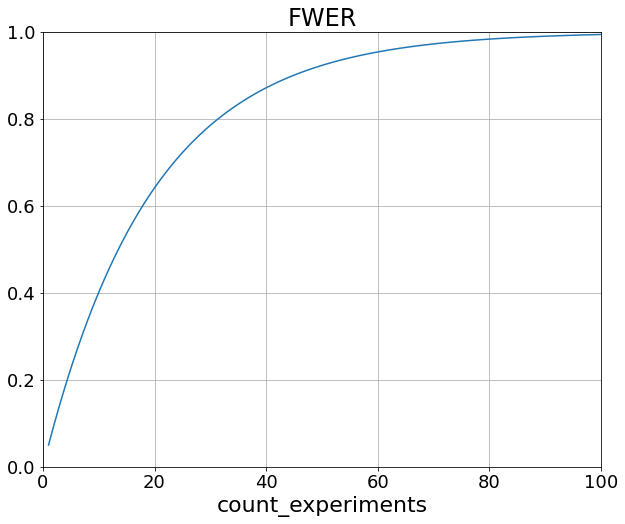

In [3]:
alpha = 0.05

count_experiments = np.arange(1, 101)
array_fwer = 1 - (1 - alpha) ** count_experiments

plt.plot(count_experiments, array_fwer, '-')
plt.grid()
plt.ylim([0, 1])
plt.xlim([0, 100])
plt.xlabel('count_experiments')
plt.title('FWER')
plt.show()

При увеличении кол-ва экспериментов, вероятность допустить хоть одну ошибку I рода быстро увеличивается.

### 1.1.1 Метод Бонферрони
Пусть у нас есть N АА-тестов. Сгенерируем N pvalue из равномерного распределения на [0, 1], предполагая, что верна нулевая гипотеза о равенстве средних. Запомним есть ли среди этих N тестов ошибки I рода. Повторим эту процедуру много раз, чтобы оценить FWER.

In [4]:
np.random.seed(125)

alpha = 0.05
size = 50

list_pvalues = [np.random.rand(size) for _ in range(1000)]
res = [int((pvalues <= alpha).sum() > 0) for pvalues in list_pvalues]
print(f'FWER без поправок: {np.mean(res):0.3f}')

FWER без поправок: 0.916


Применим метод Бонферрони к сгенерированным pvalue.

In [5]:
def method_bonferroni(pvalues, alpha=0.05):
    """Применяет метод Бонферрони для проверки значимости изменений.
  
    pvalues - List[float] - список pvalue.
    alpha - float, уровень значимости.
    return - np.array, массив из нулей и единиц, 0 - эффекта нет, 1 - эффект есть.
    """
    m = len(pvalues)
    alpha_ = alpha / m
    res = (np.array(pvalues) <= alpha_).astype(int)
    return res


res_bonferroni = [int(np.sum(method_bonferroni(pvalues)) > 0) for pvalues in list_pvalues]
print(f'FWER с поправкой Бонферрони: {np.mean(res_bonferroni):0.3f}')

FWER с поправкой Бонферрони: 0.042


Получили FWER не превышающее значение alpha.

Есть готовая реализация функция для работы с множественным тестирование, которая корректирует pvalue.

Сравним результаты

In [6]:
from statsmodels.sandbox.stats.multicomp import multipletests 

In [7]:
multipletests(list_pvalues[0], alpha=alpha, method='bonferroni')

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False]),
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.45381296, 1.        , 1.        , 0.11647981,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 

In [8]:
np.clip(list_pvalues[0] * size, 0, 1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.45381296, 1.        , 1.        , 0.11647981,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

Функция выдаёт скорректированные $pvalue^* = min([1, pvalue \times size])$, что эквивалентно сравнению исходного pvalue с порогом $\dfrac{\alpha}{size}$.

In [9]:
res_bonferroni = [
    int(True in multipletests(pvalues, alpha=alpha, method='bonferroni')[0])
    for pvalues in list_pvalues
]
print(f'FWER с поправкой Бонферрони: {np.mean(res_bonferroni):0.3f}')

FWER с поправкой Бонферрони: 0.042


Получили такой же результат

### 1.1.2. Метод Холма. Задание.

Аналогично функции для метода бонферрони, реализуйте функцию для метода Холма. Напомнить себе что такое метод Холма можно по этому видео https://www.coursera.org/lecture/stats-for-data-analysis/fwer-mietod-kholma-prJRo
Функция также должна возвращать массив из нулей и единиц, 0 - эффекта нет, 1 - эффект есть.
Сравните с соответсвующей функцией из multipletests из statsmodels. 

In [10]:
def method_holm(pvalues, alpha=0.05):
    """Применяет метод Холма для проверки значимости изменений.
  
    pvalues - List[float] - список pvalue.
    alpha - float, уровень значимости.
    return - np.array, массив из нулей и единиц, 0 - эффекта нет, 1 - эффект есть.
    """
   # Your Code here 

    #сортируем p-values в порядке возрастания и для каждого считаем соответствующую альфу
    #далее получаем массив из 0 и 1 с помощью поэлементного сравнения
    
    pvalues.sort()
    m = len(pvalues)
    alphas = np.zeros(m)
    for i in range(m):
        alphas[i] = alpha / (m - i + 1)
        
    truth_array = pvalues <= alphas
    res = truth_array * 1
    
    #При появлении первого нуля (pvalues > alphas) - все следующие нули
    for i in range(len(res)):
        if (res[i] == 0):
            res[i:] = 0
            break
    
    ###########
    return res

In [11]:
res_holm = [int(np.sum(method_holm(pvalues)) > 0) for pvalues in list_pvalues]
print(f'FWER с поправкой Холма: {np.mean(res_holm):0.3f}')

FWER с поправкой Холма: 0.040


Проверка встроенным методом

In [12]:
method_holm(list_pvalues[0])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [13]:
multipletests(list_pvalues[0], alpha=alpha, method='holm')[0] #bonferroni holm

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [14]:
res_holm = [
    int(True in multipletests(pvalues, alpha=alpha, method='holm')[0])
    for pvalues in list_pvalues
]
print(f'FWER с поправкой Холма: {np.mean(res_holm):0.3f}')

FWER с поправкой Холма: 0.042


Получилась незначительная разница